# 단어 수준 텍스트 생성

이 노트북은 아래 문서에 실려 있는 예제를 실습하면서 작성한 것입니다.

* [Python for NLP: Deep Learning Text Generation with Keras](https://stackabuse.com/python-for-nlp-deep-learning-text-generation-with-keras/) - Usman Malik on Stack Abuse

## 라이브러리 및 데이터 세트 준비

In [1]:
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.utils import to_categorical
from random import randint
import re

2024-03-15 18:25:43.651959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 18:25:43.730686: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-15 18:25:43.732863: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-15 18:25:43.732872: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [2]:
import nltk
nltk.download('gutenberg')
from nltk.corpus import gutenberg as gut

print(gut.fileids())

[nltk_data] Downloading package gutenberg to /home/wjeong/nltk_data...


['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


[nltk_data]   Unzipping corpora/gutenberg.zip.


In [4]:
macbeth_text = nltk.corpus.gutenberg.raw('shakespeare-macbeth.txt')
print(macbeth_text[:500])

[The Tragedie of Macbeth by William Shakespeare 1603]


Actus Primus. Scoena Prima.

Thunder and Lightning. Enter three Witches.

  1. When shall we three meet againe?
In Thunder, Lightning, or in Raine?
  2. When the Hurley-burley's done,
When the Battaile's lost, and wonne

   3. That will be ere the set of Sunne

   1. Where the place?
  2. Vpon the Heath

   3. There to meet with Macbeth

   1. I come, Gray-Malkin

   All. Padock calls anon: faire is foule, and foule is faire,
Houer through 


## 데이터 정제

In [5]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence.lower()

macbeth_text = preprocess_text(macbeth_text)
macbeth_text[:500]

' the tragedie of macbeth by william shakespeare actus primus scoena prima thunder and lightning enter three witches when shall we three meet againe in thunder lightning or in raine when the hurley burley done when the battaile lost and wonne that will be ere the set of sunne where the place vpon the heath there to meet with macbeth come gray malkin all padock calls anon faire is foule and foule is faire houer through the fogge and filthie ayre exeunt scena secunda alarum within enter king malcom'

## 텍스트 인코딩

In [7]:
from nltk.tokenize import word_tokenize

macbeth_text_words = (word_tokenize(macbeth_text))
n_words = len(macbeth_text_words)
unique_words = len(set(macbeth_text_words))

print('Total Words: %d' % n_words)
print('Unique Words: %d' % unique_words)

Total Words: 17250
Unique Words: 3436


In [8]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=3437)
tokenizer.fit_on_texts(macbeth_text_words)

vocab_size = len(tokenizer.word_index) + 1
word_2_index = tokenizer.word_index

print(macbeth_text_words[500])
print(word_2_index[macbeth_text_words[500]])

comparisons
1456


## 훈련 데이터 준비

In [9]:
input_sequence = []
output_words = []
input_seq_length = 100

for i in range(0, n_words - input_seq_length , 1):
    in_seq = macbeth_text_words[i:i + input_seq_length]
    out_seq = macbeth_text_words[i + input_seq_length]
    input_sequence.append([word_2_index[word] for word in in_seq])
    output_words.append(word_2_index[out_seq])
    
print(input_sequence[0])

[1, 869, 4, 40, 60, 1358, 1359, 408, 1360, 1361, 409, 265, 2, 870, 31, 190, 291, 76, 36, 30, 190, 327, 128, 8, 265, 870, 83, 8, 1362, 76, 1, 1363, 1364, 86, 76, 1, 1365, 354, 2, 871, 5, 34, 14, 168, 1, 292, 4, 649, 77, 1, 220, 41, 1, 872, 53, 3, 327, 12, 40, 52, 1366, 1367, 25, 1368, 873, 328, 355, 9, 410, 2, 410, 9, 355, 1369, 356, 1, 1370, 2, 874, 169, 103, 127, 411, 357, 149, 31, 51, 1371, 329, 107, 12, 358, 412, 875, 1372, 51, 20, 170, 92, 9]


In [10]:
X = np.reshape(input_sequence, (len(input_sequence), input_seq_length, 1))
X = X / float(vocab_size)

y = to_categorical(output_words)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (17150, 100, 1)
y shape: (17150, 3437)


## 모델 구성

In [17]:
model = Sequential()
model.add(LSTM(100, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(y.shape[1], activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 100)          40800     
                                                                 
 lstm_7 (LSTM)               (None, 100, 100)          80400     
                                                                 
 lstm_8 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 3437)              347137    
                                                                 
Total params: 548,737
Trainable params: 548,737
Non-trainable params: 0
_________________________________________________________________


## 모델 훈련

In [18]:
history = model.fit(X, y, batch_size=128, epochs=100, verbose=1)

Epoch 1/100
134/134 [==============================] - 25s 168ms/step - loss: 7.0367 - accuracy: 0.0360
Epoch 2/100
134/134 [==============================] - 22s 165ms/step - loss: 6.6551 - accuracy: 0.0362
Epoch 3/100
134/134 [==============================] - 22s 163ms/step - loss: 6.6370 - accuracy: 0.0367
Epoch 4/100
134/134 [==============================] - 22s 164ms/step - loss: 6.6308 - accuracy: 0.0363
Epoch 5/100
134/134 [==============================] - 22s 165ms/step - loss: 6.6275 - accuracy: 0.0362
Epoch 6/100
134/134 [==============================] - 22s 167ms/step - loss: 6.6245 - accuracy: 0.0375
Epoch 7/100
134/134 [==============================] - 23s 171ms/step - loss: 6.6209 - accuracy: 0.0375
Epoch 8/100
134/134 [==============================] - 23s 169ms/step - loss: 6.6184 - accuracy: 0.0382
Epoch 9/100
134/134 [==============================] - 22s 167ms/step - loss: 6.6169 - accuracy: 0.0366
Epoch 10/100
134/134 [==============================] - 22s 168m

134/134 [==============================] - 22s 164ms/step - loss: 4.9940 - accuracy: 0.0654
Epoch 80/100
134/134 [==============================] - 22s 165ms/step - loss: 4.8816 - accuracy: 0.0762
Epoch 81/100
134/134 [==============================] - 22s 167ms/step - loss: 4.8473 - accuracy: 0.0827
Epoch 82/100
134/134 [==============================] - 22s 165ms/step - loss: 4.8172 - accuracy: 0.0889
Epoch 83/100
134/134 [==============================] - 22s 163ms/step - loss: 4.7940 - accuracy: 0.0935
Epoch 84/100
134/134 [==============================] - 22s 165ms/step - loss: 4.7715 - accuracy: 0.0983
Epoch 85/100
134/134 [==============================] - 22s 165ms/step - loss: 4.7511 - accuracy: 0.1013
Epoch 86/100
134/134 [==============================] - 22s 166ms/step - loss: 4.7323 - accuracy: 0.1030
Epoch 87/100
134/134 [==============================] - 22s 164ms/step - loss: 4.7101 - accuracy: 0.1084
Epoch 88/100
134/134 [==============================] - 22s 163ms/st

dict_keys(['loss', 'accuracy'])


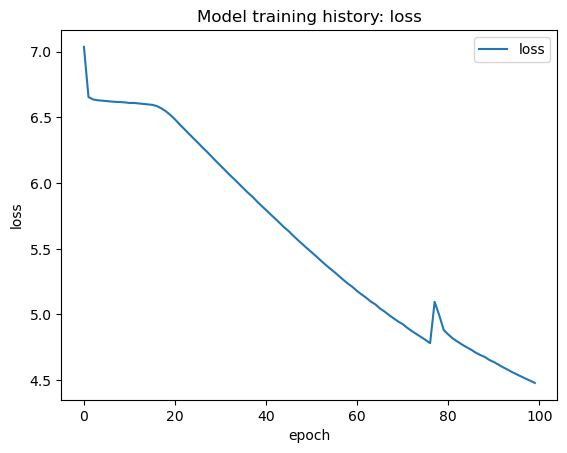

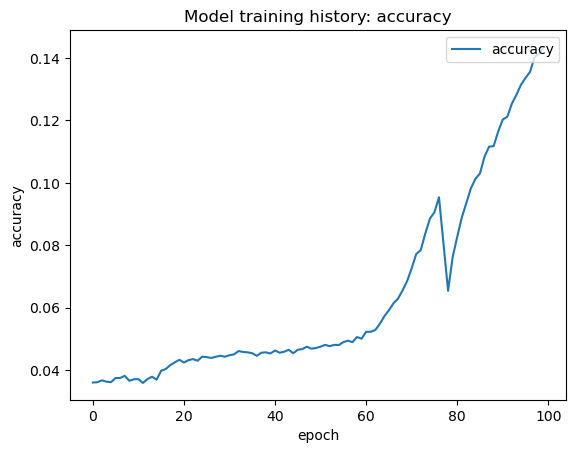

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Model training history: loss')
plt.legend(['loss'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Model training history: accuracy')
plt.legend(['accuracy'], loc='upper right')
plt.show()

## 텍스트 생성

입력 텍스트를 선택합니다.

In [20]:
random_seq_index = np.random.randint(0, len(input_sequence)-1)
random_seq = input_sequence[random_seq_index]

index_2_word = dict(map(reversed, word_2_index.items()))

word_sequence = [index_2_word[value] for value in random_seq]

print(' '.join(word_sequence))

how much is done exeunt scaena quarta banquet prepar enter macbeth lady rosse lenox lords and attendants macb you know your owne degrees sit downe at first and last the hearty welcome lords thankes to your maiesty macb our selfe will mingle with society and play the humble host our hostesse keepes her state but in best time we will require her welcome la pronounce it for me sir to all our friends for my heart speakes they are welcome enter first murtherer macb see they encounter thee with their harts thanks both sides are euen heere ile sit th


예측 결과와 비교하기 위하여 입력 데이터 이후의 단어 100개를 출력합니다.

In [28]:
random_seq_2 = input_sequence[random_seq_index+100]
word_sequence_2 = [index_2_word[value] for value in random_seq_2]

print(' '.join(word_sequence_2))

mid st be large in mirth anon wee drinke measure the table round there blood vpon thy face mur tis banquo then macb tis better thee without then he within is he dispatch mur my lord his throat is cut that did for him mac thou art the best th cut throats yet hee good that did the like for fleans if thou did st it thou art the non pareill mur most royall sir fleans is scap macb then comes my fit againe had else beene perfect whole as the marble founded as the rocke as broad and generall


입력 데이터 이후의 단어 100개를 생성합니다.

In [29]:
for i in range(100):
    int_sample = np.reshape(random_seq, (1, len(random_seq), 1))
    int_sample = int_sample / float(vocab_size)

    predicted_word_index = model.predict(int_sample, verbose=0)

    predicted_word_id = np.argmax(predicted_word_index)
    seq_in = [index_2_word[index] for index in random_seq]

    word_sequence.append(index_2_word[ predicted_word_id])

    random_seq.append(predicted_word_id)
    random_seq = random_seq[1:len(random_seq)]
    
final_output = ""
for word in word_sequence:
    final_output = final_output + " " + word

print(final_output)

 how much is done exeunt scaena quarta banquet prepar enter macbeth lady rosse lenox lords and attendants macb you know your owne degrees sit downe at first and last the hearty welcome lords thankes to your maiesty macb our selfe will mingle with society and play the humble host our hostesse keepes her state but in best time we will require her welcome la pronounce it for me sir to all our friends for my heart speakes they are welcome enter first murtherer macb see they encounter thee with their harts thanks both sides are euen heere ile sit th mid and the titles of the the deuoure of the the deuoure of the the deuoure of the the deuoure of the the deuoure of the the deuoure of the the deuoure of the the deuoure of the the deuoure of the the deuoure of the the deuoure of the the deuoure of the the deuoure of the the deuoure of the the deuoure of the the deuoure of the the deuoure of the the deuoure of the the deuoure of the the deuoure of the the deuoure of the the deuoure of the the d